# Reinforcement Learning : Code Connect 4 Game 

As part of this project, we implemented a Connect 4 game that operates with a simple version of the AlphaZero algorithm. To do this we followed freeCodeCamp tutorial, originally intented for the TicTacToe game, and which we adapted for Connect 4 game. 

Tutorial : https://www.youtube.com/watch?v=wuSQpLinRB4

Members of the group : AMEDEE Romain, GERTNER Victor, MERRHEIM Maïssane

In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import math 
import numpy as np 
from scipy.signal import convolve2d
from tqdm.notebook import trange

torch.manual_seed(0) #reproduceable results

Firstly, we first implemented a class called Connect4, where we established the basic rules of the game, including functions like get_legal_actions() and check_win() functions.
To detect if 4 pawns were aligned consecutively, whether it is in diagonally or horizontally or vertically, we used a kernel of size 4 and convolve2d layers.


# Connect 4 Game : class Connect4

In [17]:
class Connect4: 

    def __init__(self): 
        self.row_count = 6
        self.column_count = 7
        self.action_size = self.column_count

    def get_initial_state(self): 
        return np.zeros((self.row_count, self.column_count))
    
    def get_next_state(self, state, action, player):
        #action integer between 0 and 8 
        """row = action // self.column_count
        column = action % self.column_count
        state[row,column] = player
        return state"""

        column = action
        for row in range(self.row_count-1, -1, -1):
            if state[row, column] == 0:
                state[row, column] = player
                break
        return state 

    def get_legal_actions(self, state): 
        return np.array([state[0, col] == 0 for col in range(self.column_count)])


    def check_win(self, state, action): 
        if action == None : 
            return False 
            
        kernel = np.ones((1, 4), dtype=int)
        
        # Horizontal and vertical checks
        horizontal_check = convolve2d(state, kernel, mode='valid')
        vertical_check = convolve2d(state, kernel.T, mode='valid')

        # Diagonal checks
        diagonal_kernel = np.eye(4, dtype=int)
        main_diagonal_check = convolve2d(state, diagonal_kernel, mode='valid')
        anti_diagonal_check = convolve2d(state, np.fliplr(diagonal_kernel), mode='valid')
        
        # Check for winner
        if any(cond.any() for cond in [horizontal_check == 4, vertical_check == 4, main_diagonal_check == 4, anti_diagonal_check == 4]):
            return 1
        elif any(cond.any() for cond in [horizontal_check == -4, vertical_check == -4, main_diagonal_check == -4, anti_diagonal_check == -4]):
            return -1

        # No winner
        return 0  

    def get_value_and_terminated(self, state, action): 
        if self.check_win(state, action) : 
            # value = 1 , terminated = True
            return 1, True
        if np.sum(self.get_legal_actions(state)) == 0: 
            #pas de gagnant value = 1, terminated = True 
            return 0, True 
        return 0, False
    
    def get_opponent(self, player): 
        return -player

    def get_opponent_value(self, value): 
        return -value

    def change_perspective(self, state, player): 
        return state * player 
    
    def get_encoded_state(self, state): 
        encoded_state = np.stack(
            (state == -1, state == 0, state == 1)
        ).astype(np.float32)
        return encoded_state

# Neural Networks : ResBlock and ResNet classes

We then implemented two neural networks : Resblock and the Resnet classes. These neural networks architectures enable to train deep neural networks and often used for image recognition. In our implementation of the AlphaZero network, Resnet takes in
input a matrix that represents the board state and return to outputs :
- the value of the position of the pawn : either 1 if player 1 wins or -1 if player 1 looses.
- a policy,that represents a vector a prior probabilities for each next legal move.


In [18]:
class ResBlock(nn.Module):
    def __init__(self, num_hidden): 
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self, x): 
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual 
        x + F.relu(x)
        return x

In [19]:
class ResNet(nn.Module): 
    def __init__(self, game, num_resBlocks, num_hidden): 
        super().__init__()
        self.startBlock = nn.Sequential(
            nn.Conv2d(3, num_hidden, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_hidden), 
            nn.ReLU()
            )
        self.backBone = nn.ModuleList(
            [ResBlock(num_hidden) for i in range(num_resBlocks)]
        )
        self.policyHead = nn.Sequential(
            nn.Conv2d(num_hidden, 32, kernel_size = 3, padding=1),
            nn.BatchNorm2d(32), 
            nn.ReLU(),
            nn.Flatten(), 
            nn.Linear(32 * game.row_count * game.column_count, game.action_size)
        )
        self.valueHead = nn.Sequential(
            nn.Conv2d(num_hidden, 3,  kernel_size=3, padding=1), 
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3 * game.row_count * game.column_count, 1), 
            nn.Tanh()
        )

    def forward(self, x): 
        x = self.startBlock(x)
        for resBlock in self.backBone:
            x = resBlock(x)
        policy = self.policyHead(x)
        value = self.valueHead(x)
        return policy, value

# Standard MCTS (Monte Carlo Tree Search) Algorithm

In order to run a MCTS algorithm (Monte-Carlo Tree Search) algorithm, we first needed to implement a class called \texttt{Node}, that implement the 3 main steps of the MCTS algorithm for the AlphaZero model : 
- Selection of a node : select()
- Expansion of a node : expand()
- Backpropagation :backpropagate()


The function get_ucb() enables to compute the ucb score of a node following this formula : 
$$ v_{i} + C \times \frac{\sqrt{\ln N}}{n_i} $$


with $v_i$ the estimated value of the node $i$,  $n_i$ is the number of the times the node has been visited and  $N$ is the total number of times that its parent has been visited.

However, for the first step, we decided to implement a 'standard' MCTS class that would "simulate" playouts instead of learning them, so that we can compare the different generated policies between the standard MCTS algorithm, and the MCTS algorithm adapted to AlphaZero. 

In [ ]:
import math 

class Node : 
    def __init__(self, game, args, state, parent=None, action_taken=None): 
        self.game = game 
        self. args = args 
        self.state = state 
        self.parent = parent 
        self.action_taken = action_taken 

        self.children = []
        self.expandable_moves = game.get_legal_actions(state)

        self.visit_count = 0 
        self.value_sum = 0

    def is_fully_expanded(self):
        return np.sum(self.expandable_moves) == 0 and len(self.children) > 0

    def select(self): 
        best_child = None 
        best_ucb = -np.inf 
        for child in self.children : 
            ucb = self.get_ucb(child)
            if ucb > best_ucb: 
                best_child = child
                best_ucb = ucb 

            return best_child
    
    def get_ucb(self, child): 
        q_value = 1 - (child.value_sum / child.visit_count) + 1 / 2 
        #the child and the parent are different players -> put our opponent in a bad move 
        # so we prefer a bad position with a bad q_value for the opponent 
        return q_value + self.args['C'] * math.sqrt(math.log(self.visit_count)/child.visit_count)

    def expand(self): 
        indices = np.where(self.expandable_moves == 1)[0]  # Obtenir les indices unidimensionnels
        action = np.random.choice(indices)
        #action = np.random.choice([np.where(self.expandable_moves == 1)[0]])
        #make this move no longer exapndable 
        self.expandable_moves[action] = 0 

        child_state = self.state.copy()
        child_state = self.game.get_next_state(child_state, action, 1)
        #never change the player change the state of the child and change the perception 
        child_state = self.game.change_perspective(child_state, player=-1)

        child = Node(self.game, self.args, child_state, self, action)
        # we are the parent 
        self.children.append(child)
        return child

    def simulate(self): 
        value, is_terminal = self.game.get_value_and_terminated(self.state, self.action_taken)
        value = self.game.get_opponent_value(value)

        if is_terminal : 
            return value 
        rollout_state = self.state.copy()
        rollout_player = 1
        while True : 
            legal_actions = self.game.get_legal_actions(rollout_state)
            action = np.random.choice(np.where(legal_actions == 1)[0])
            rollout_state = self.game.get_next_state(rollout_state,action,rollout_player)
            value, is_terminal = self.game.get_value_and_terminated(rollout_state, action)
            if is_terminal: 
                if rollout_player == -1: 
                    value = self.game.get_opponent_value(value)
                return value 
            rollout_player = self.game.get_opponent(rollout_player)
            
    def backpropagate(self, value): 
        self.value_sum += value 
        self.visit_count +=1 
        value = self.game.get_opponent_value(value)
        if self.parent is not None: 
            self.parent.backpropagate(value)

class MCTS: 
    def __init__(self, game, args): 
        self.game = game 
        self.args = args 
    
    def search(self, state): 
        #define root node 
        root = Node(self.game, self.args, state)
        for search in range(self.args['num_searches']): 
            node = root
            # selection 
            while node.is_fully_expanded():
                node = node.select()
                #chcek if the node is a terminated one 
                #action taken -> action of the opponent
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)

            # expansion 
            if not is_terminal: 
                node = node.expand()
                 
                # simulation
                value = node.simulate() 
            # backpropagation 
            node.backpropagate(value)

        # return visit_counts 
        action_probs = np.zeros(self.game.action_size)
        for child in root.children: 
            action_probs[child.action_taken] = child.visit_count 
        action_probs /= np.sum(action_probs)
        return action_probs

## Simulation and test 

[[[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1.]]

 [[1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 0. 1. 1. 1. 0.]]

 [[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0.]]]
value : 0.04013870283961296 policy : [0.14335124 0.18187433 0.08020195 0.12876034 0.17010544 0.10559373
 0.19011292]


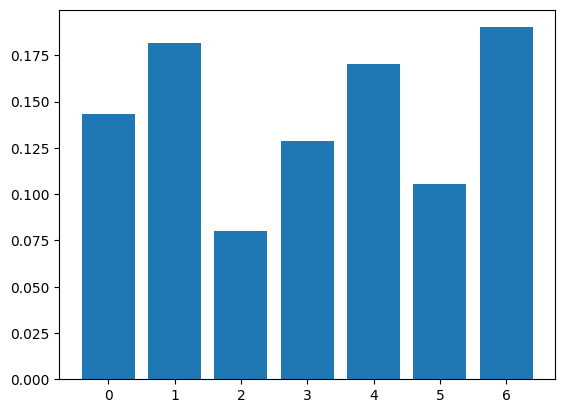

In [20]:
import matplotlib.pyplot as plt
connect4 = Connect4()

state = connect4.get_initial_state()
state = connect4.get_next_state(state, 2, 1)
state = connect4.get_next_state(state, 6, -1)

encoded_state = connect4.get_encoded_state(state)
print(encoded_state)

tensor_state = torch.tensor(encoded_state).unsqueeze(0)

model = ResNet(connect4, 4, 64)
policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print("value :", value, "policy :", policy)

plt.bar(range(connect4.action_size), policy)
plt.show()

# MCTS (adapted to AlphaZero, without the simluation step)

In [23]:
class MCTS: 
    def __init__(self, game, args, model): 
        self.game = game 
        self.args = args 
        self.model = model 
    
    @torch.no_grad() # don't want to use policy and value for training
    #faster
    def search(self, state): 
        #define root node 
        root = Node(self.game, self.args, state)
        for search in range(self.args['num_searches']): 
            node = root
            # selection 
            while node.is_fully_expanded():
                node = node.select()
                #chcek if the node is a terminated one 
                #action taken -> action of the opponent
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)

            # expansion 
            if not is_terminal: 
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state)).unsqueeze(0)
                )
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                legal_actions = self.game.get_legal_actions(node.state)
                policy += legal_actions
                policy /= np.sum(policy)

                #just want to get the float from the value head
                value = value.item()

                node.expand(policy)
                #we remove the simulation part 
    
            # backpropagation 
            node.backpropagate(value)

        # return visit_counts 
        action_probs = np.zeros(self.game.action_size)
        for child in root.children: 
            action_probs[child.action_taken] = child.visit_count 
        action_probs /= np.sum(action_probs)
        return action_probs


# AlphaZero class

In [24]:
import random
class AlphaZero: 
    def __init__(self, model, optimizer, game, args): 
        self.model = model 
        self.optimizer = optimizer
        self.game = game 
        self.args = args
        self.mcts = MCTS(game, args, model)

    def selfPlay(self):
        memory = []
        player = 1
        state = self.game.get_initial_state()
        
        while True:
            neutral_state = self.game.change_perspective(state, player)
            action_probs = self.mcts.search(neutral_state)
            
            memory.append((neutral_state, action_probs, player))
            action = np.random.choice(self.game.action_size, p=action_probs)
            state = self.game.get_next_state(state, action, player)
            value, is_terminal = self.game.get_value_and_terminated(state, action)
            
            if is_terminal:
                returnMemory = []
                for hist_neutral_state, hist_action_probs, hist_player in memory:
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    returnMemory.append((
                        self.game.get_encoded_state(hist_neutral_state),
                        hist_action_probs,
                        hist_outcome
                    ))
                return returnMemory
            
            player = self.game.get_opponent(player)

    def train(self, memory): 
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']): 
            sample = memory[batchIdx: min(len(memory)-1,batchIdx + self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample)

            state, policy_targets, value_targets = np.array(state), np.array(policy_targets),  np.array(value_targets).reshape(-1,1)
            state = torch.tensor(state, dtype = torch.float32)
            policy_targets = torch.tensor(policy_targets, dtype = torch.float32)
            value_targets = torch.tensor(value_targets, dtype = torch.float32)

            out_policy, out_value = self.model(state)
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss

            #minimize the loss by backpropagating 
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()


    def learn(self): 
        for iteration in range(self.args['num_iterations']): 
            print("iteration :", iteration)
            memory = []

            self.model.eval()
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']): 
                print("selfPlay_iteration :", selfPlay_iteration)
                memory += self.selfPlay()
  
            self.model.train()
            for epoch in trange(self.args['num_epochs']): 
                print("epoch :", epoch)
                self.train(memory)
            
            torch.save(self.model.state_dict(), f"model_{iteration}.pt")
            torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}.pt")

# Test of the Game : look at the generated policies for a given state

In [25]:
connect4 = Connect4()
model = ResNet(connect4, 4, 64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
args = {
    'C': 2, 
    'num_searches': 60, 
    'num_iterations': 3, 
    'num_selfPlay_iterations':100, 
    'num_epochs': 3,
    'batch_size': 16
}

alphaZero = AlphaZero(model, optimizer, connect4, args)
alphaZero.learn()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

[[[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1.]]

 [[1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 0. 1. 1. 1. 0.]]

 [[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0.]]]
value : -0.11234381049871445 policy : [8.1682134e-01 5.3588249e-04 1.4727749e-03 1.5530065e-01 2.1377509e-02
 3.5948004e-03 8.9707057e-04]


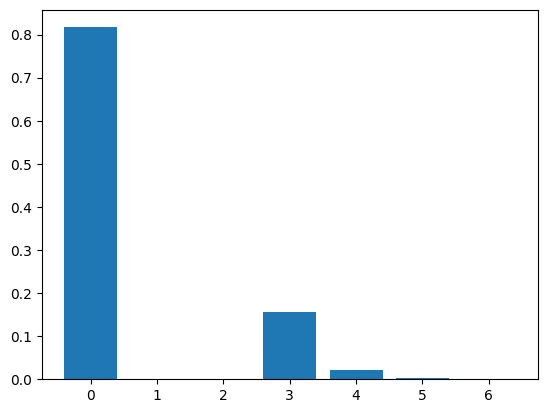

In [27]:
import matplotlib.pyplot as plt
connect4 = Connect4()

state = connect4.get_initial_state()
state = connect4.get_next_state(state, 2, 1)
state = connect4.get_next_state(state, 6, -1)

encoded_state = connect4.get_encoded_state(state)
print(encoded_state)

tensor_state = torch.tensor(encoded_state).unsqueeze(0)

model = ResNet(connect4, 4, 64)
model.load_state_dict(torch.load('model_2_<__main__.Connect4 object at 0x7fe2310b78b0>.pt'))
model.eval()


policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print("value :", value, "policy :", policy)

plt.bar(range(connect4.action_size), policy)
plt.show()

# AlphaZero Version with Dirichlet 

In [33]:
class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None, prior=0, visit_count=0):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken
        self.prior = prior
        
        self.children = []
        
        self.visit_count = visit_count
        self.value_sum = 0
        
    def is_fully_expanded(self):
        return len(self.children) > 0
    #SELECTION
    def select(self):
        best_child = None
        best_ucb = -np.inf
        
        for child in self.children:
            ucb = self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
                
        return best_child

    # Compute the ucb score to select the best child 
    def get_ucb(self, child):
        if child.visit_count == 0:
            q_value = 0
        else:
            q_value = 1 - ((child.value_sum / child.visit_count) + 1) / 2
        return q_value + self.args['C'] * (math.sqrt(self.visit_count) / (child.visit_count + 1)) * child.prior
    
    def expand(self, policy):
        for action, prob in enumerate(policy):
            if prob > 0:
                child_state = self.state.copy()
                child_state = self.game.get_next_state(child_state, action, 1)
                child_state = self.game.change_perspective(child_state, player=-1)

                child = Node(self.game, self.args, child_state, self, action, prob)
                self.children.append(child)
                
        return child

    #BACKPROPAGATION 
    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1
        
        value = self.game.get_opponent_value(value)
        if self.parent is not None:
            self.parent.backpropagate(value)  

In [34]:

class MCTS:
    def __init__(self, game, args, model):
        self.game = game
        self.args = args
        self.model = model
        
    @torch.no_grad()
    def search(self, state):
        root = Node(self.game, self.args, state, visit_count=1)
        # ----------------------------dirichlet--------------------------------------
        policy, _ = self.model(
            torch.tensor(self.game.get_encoded_state(state)).unsqueeze(0)
        )
        policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
        policy = (1 - self.args['dirichlet_epsilon']) * policy + self.args['dirichlet_epsilon'] \
            * np.random.dirichlet([self.args['dirichlet_alpha']] * self.game.action_size)
        
        valid_moves = self.game.get_legal_actions(state)
        policy *= valid_moves
        policy /= np.sum(policy)
        root.expand(policy)
        # ----------------------------dirichlet--------------------------------------
        for search in range(self.args['num_searches']):
            node = root
            # selection 
            
            while node.is_fully_expanded():
                node = node.select()
                #check if the node is a terminated one 
                #action taken -> action of the opponent
                
            value, is_terminal = self.game.get_value_and_terminated(node.state, node.action_taken)
            value = self.game.get_opponent_value(value)
            
            # expansion 
            if not is_terminal:
                policy, value = self.model(
                    torch.tensor(self.game.get_encoded_state(node.state)).unsqueeze(0)
                )
                policy = torch.softmax(policy, axis=1).squeeze(0).cpu().numpy()
                valid_moves = self.game.get_legal_actions(node.state)
                policy *= valid_moves
                policy /= np.sum(policy)

                #just want to get the float from the value head
                value = value.item()
                
                node.expand(policy)
                #we remove the simulation part 
                
            node.backpropagate(value)    
            
        # return visit_counts  
        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs
        

In [35]:
import random
class AlphaZero: 
    def __init__(self, model, optimizer, game, args): 
        self.model = model 
        self.optimizer = optimizer
        self.game = game 
        self.args = args
        self.mcts = MCTS(game, args, model)

    def selfPlay(self):
        memory = []
        player = 1
        state = self.game.get_initial_state()
        
        while True:
            neutral_state = self.game.change_perspective(state, player)
            action_probs = self.mcts.search(neutral_state)
            
            memory.append((neutral_state, action_probs, player))
            temperature_action_probs = action_probs ** (1 / self.args['temperature'])
            action = np.random.choice(self.game.action_size, p=action_probs) 
            state = self.game.get_next_state(state, action, player)
            value, is_terminal = self.game.get_value_and_terminated(state, action)
            
            if is_terminal:
                returnMemory = []
                for hist_neutral_state, hist_action_probs, hist_player in memory:
                    hist_outcome = value if hist_player == player else self.game.get_opponent_value(value)
                    returnMemory.append((
                        self.game.get_encoded_state(hist_neutral_state),
                        hist_action_probs,
                        hist_outcome
                    ))
                return returnMemory
            
            player = self.game.get_opponent(player)

    def train(self, memory): 
        random.shuffle(memory)
        for batchIdx in range(0, len(memory), self.args['batch_size']): 
            sample = memory[batchIdx: min(len(memory)-1,batchIdx + self.args['batch_size'])]
            state, policy_targets, value_targets = zip(*sample)

            state, policy_targets, value_targets = np.array(state), np.array(policy_targets),  np.array(value_targets).reshape(-1,1)
            state = torch.tensor(state, dtype = torch.float32)
            policy_targets = torch.tensor(policy_targets, dtype = torch.float32)
            value_targets = torch.tensor(value_targets, dtype = torch.float32)

            out_policy, out_value = self.model(state)
            policy_loss = F.cross_entropy(out_policy, policy_targets)
            value_loss = F.mse_loss(out_value, value_targets)
            loss = policy_loss + value_loss

            #minimize the loss by backpropagating 
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()


    def learn(self): 
        for iteration in range(self.args['num_iterations']): 
            print("iteration :", iteration)
            memory = []

            self.model.eval()
            for selfPlay_iteration in trange(self.args['num_selfPlay_iterations']): 
                print("selfPlay_iteration :", selfPlay_iteration)
                memory += self.selfPlay()
  
            self.model.train()
            for epoch in trange(self.args['num_epochs']): 
                print("epoch :", epoch)
                self.train(memory)
            
            torch.save(self.model.state_dict(), f"model_{iteration}.pt")
            torch.save(self.optimizer.state_dict(), f"optimizer_{iteration}.pt")

In [36]:
connect4 = Connect4()
model = ResNet(connect4, 4, 64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


args = {
    'C': 2,
    'num_searches': 60, 
    'num_iterations': 3, 
    'num_selfPlay_iterations':100, 
    'num_epochs': 3,
    'batch_size': 16,
    'temperature': 1.25,
    'dirichlet_epsilon': 0.25,
    'dirichlet_alpha': 0.3
}



alphaZero = AlphaZero(model, optimizer, connect4, args)
alphaZero.learn()

iteration : 0


  0%|          | 0/100 [00:00<?, ?it/s]

selfPlay_iteration : 0
selfPlay_iteration : 1
selfPlay_iteration : 2
selfPlay_iteration : 3
selfPlay_iteration : 4
selfPlay_iteration : 5
selfPlay_iteration : 6
selfPlay_iteration : 7
selfPlay_iteration : 8
selfPlay_iteration : 9
selfPlay_iteration : 10
selfPlay_iteration : 11
selfPlay_iteration : 12
selfPlay_iteration : 13
selfPlay_iteration : 14
selfPlay_iteration : 15
selfPlay_iteration : 16
selfPlay_iteration : 17
selfPlay_iteration : 18
selfPlay_iteration : 19
selfPlay_iteration : 20
selfPlay_iteration : 21
selfPlay_iteration : 22
selfPlay_iteration : 23
selfPlay_iteration : 24
selfPlay_iteration : 25
selfPlay_iteration : 26
selfPlay_iteration : 27
selfPlay_iteration : 28
selfPlay_iteration : 29
selfPlay_iteration : 30
selfPlay_iteration : 31
selfPlay_iteration : 32
selfPlay_iteration : 33
selfPlay_iteration : 34
selfPlay_iteration : 35
selfPlay_iteration : 36
selfPlay_iteration : 37
selfPlay_iteration : 38
selfPlay_iteration : 39
selfPlay_iteration : 40
selfPlay_iteration : 41
se

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 0
epoch : 1
epoch : 2
iteration : 1


  0%|          | 0/100 [00:00<?, ?it/s]

selfPlay_iteration : 0
selfPlay_iteration : 1
selfPlay_iteration : 2
selfPlay_iteration : 3
selfPlay_iteration : 4
selfPlay_iteration : 5
selfPlay_iteration : 6
selfPlay_iteration : 7
selfPlay_iteration : 8
selfPlay_iteration : 9
selfPlay_iteration : 10
selfPlay_iteration : 11
selfPlay_iteration : 12
selfPlay_iteration : 13
selfPlay_iteration : 14
selfPlay_iteration : 15
selfPlay_iteration : 16
selfPlay_iteration : 17
selfPlay_iteration : 18
selfPlay_iteration : 19
selfPlay_iteration : 20
selfPlay_iteration : 21
selfPlay_iteration : 22
selfPlay_iteration : 23
selfPlay_iteration : 24
selfPlay_iteration : 25
selfPlay_iteration : 26
selfPlay_iteration : 27
selfPlay_iteration : 28
selfPlay_iteration : 29
selfPlay_iteration : 30
selfPlay_iteration : 31
selfPlay_iteration : 32
selfPlay_iteration : 33
selfPlay_iteration : 34
selfPlay_iteration : 35
selfPlay_iteration : 36
selfPlay_iteration : 37
selfPlay_iteration : 38
selfPlay_iteration : 39
selfPlay_iteration : 40
selfPlay_iteration : 41
se

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 0
epoch : 1
epoch : 2
iteration : 2


  0%|          | 0/100 [00:00<?, ?it/s]

selfPlay_iteration : 0
selfPlay_iteration : 1
selfPlay_iteration : 2
selfPlay_iteration : 3
selfPlay_iteration : 4
selfPlay_iteration : 5
selfPlay_iteration : 6
selfPlay_iteration : 7
selfPlay_iteration : 8
selfPlay_iteration : 9
selfPlay_iteration : 10
selfPlay_iteration : 11
selfPlay_iteration : 12
selfPlay_iteration : 13
selfPlay_iteration : 14
selfPlay_iteration : 15
selfPlay_iteration : 16
selfPlay_iteration : 17
selfPlay_iteration : 18
selfPlay_iteration : 19
selfPlay_iteration : 20
selfPlay_iteration : 21
selfPlay_iteration : 22
selfPlay_iteration : 23
selfPlay_iteration : 24
selfPlay_iteration : 25
selfPlay_iteration : 26
selfPlay_iteration : 27
selfPlay_iteration : 28
selfPlay_iteration : 29
selfPlay_iteration : 30
selfPlay_iteration : 31
selfPlay_iteration : 32
selfPlay_iteration : 33
selfPlay_iteration : 34
selfPlay_iteration : 35
selfPlay_iteration : 36
selfPlay_iteration : 37
selfPlay_iteration : 38
selfPlay_iteration : 39
selfPlay_iteration : 40
selfPlay_iteration : 41
se

  0%|          | 0/3 [00:00<?, ?it/s]

epoch : 0
epoch : 1
epoch : 2


[[[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1.]]

 [[1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 1. 1. 1. 1. 1.]
  [1. 1. 0. 1. 1. 1. 0.]]

 [[0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0.]]]
value : 0.247343972325325 policy : [0.2172347  0.27530435 0.07425594 0.14856645 0.08141904 0.11927931
 0.08394005]


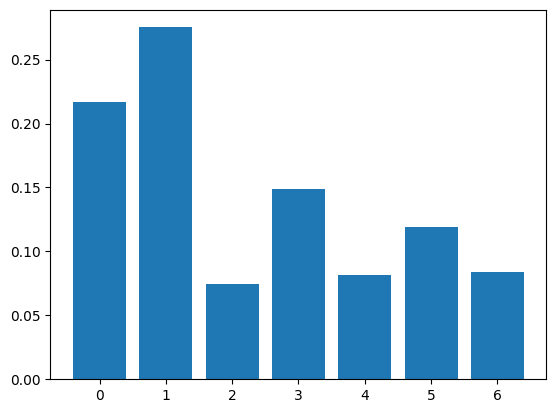

In [37]:
import matplotlib.pyplot as plt
connect4 = Connect4()

state = connect4.get_initial_state()
state = connect4.get_next_state(state, 2, 1)
state = connect4.get_next_state(state, 6, -1)

encoded_state = connect4.get_encoded_state(state)
print(encoded_state)

tensor_state = torch.tensor(encoded_state).unsqueeze(0)

model = ResNet(connect4, 4, 64)
model.load_state_dict(torch.load('model_2.pt'))
model.eval()


policy, value = model(tensor_state)
value = value.item()
policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()

print("value :", value, "policy :", policy)

plt.bar(range(connect4.action_size), policy)
plt.show()